# Max Min Fairness

### Here we try to maximize the minimal benefit that any individual might experience

Import necessary dependencies.
Note that the modules "load_compas_data_modified", "utils" and "funcs_disp_mist_modified" are adopted from "Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment" by Zafar et. al.

In [22]:
import numpy as np
import pandas as pd
from load_compas_data_modified import *
import funcs_disp_mist_modified as fdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import utils_modified as ut
from cvxpy import *
import ncvx
from scsprox import Prox

### Defining a utility function

In [10]:
# this complies with the cvxpy framework that we use to optimize
# but it doesn't give back a number
def avg_utility(y_pred, y_actual,alpha):
    #assert(y_pred.shape[0] == y.shape[0])
    n = y_actual.shape[0]
    s = sum_entries(power(((y_pred-y_actual)+10),alpha))
    return s/n 

# this is essentially the same function but it can't be used with the cvxpy framework
# we use this one when we need to produce a number as an output
def eval_util(y_pred, y_actual, alpha):
    n = y_actual.shape[0]
    s = sum(np.power((np.subtract(y_pred,y_actual)+10).astype('float'),alpha))
    return s/n 

def min_utility(y_pred, y_actual,alpha):
    #assert(y_pred.shape[0] == y.shape[0])
    n = y_actual.shape[0]
    s = min_entries(power(((y_pred-y_actual)+10),alpha))
    return s

def eval_min_util(y_pred, y_actual, alpha):
    n = y_actual.shape[0]
    s = min(np.power((np.subtract(y_pred,y_actual)+10),alpha))
    return s

### Defining functions to compute violations w.r.t. individual Fairness constraints

For the generalized entropy measure of Speicher et al a constant (they call is alpha) is needed, we use 2 and therefore call the measure GE2

In [18]:
# x1 and x2 are feature vectors, we use euclidian distance
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

def avg_Dwork_violation(y_pred, X_data):
    # go trough all pairs of predictions and see if constraints are violated
    violation_sum = 0
    n = y_pred.shape[0]
    assert(X_data.shape[0] == n)
    for i in range(n):
        for j in range(i+1,n):
            violation_sum += np.maximum(0, np.absolute(y_pred[i] - y_pred[j]) - distance(X_data[i,:],X_data[j,:]))
    return 2*violation_sum/(n*(n-1))
    
# y_pred and y_actual are vectors of predictions
# return value is a scalar
def ge2(y_pred, y_actual):
    n = y.shape[0]
    benefit = (np.subtract(y_pred,y_actual)+1)
    mu = np.average(benefit)
    return 0.5*np.average(np.power(benefit/mu,2)) - 0.5

## Importing the COMPAS dataset

Here we import the COMPAS dataset. It is preprocessed the same way as in the ProPublica study (refer to https://github.com/propublica/compas-analysis)

In [7]:
#data_type = 1
X, y, x_control = load_compas_data()

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory..

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree'] 



## Train the utility model

In [8]:
"""permute the data randomly"""
perm = list(range(0,X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
#for k in list(x_control.keys()):
for k in x_control.keys():
    x_control[k] = x_control[k][perm]

""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)


In [19]:
# a list of all sensitive attributes, in the case of the COMPAS dataset it's only 'race'
sensitive_attrs = list(x_control.keys())


# set the alpha parameter for our utility function
alpha = 1

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6 # tolerance parameter for the optimizer
loss_function = "logreg" # perform the experiments with logistic regression

num_points, num_features = x_train.shape

# initialize a random value of the weight vectors
w_uncons = Variable(num_features)
w_uncons.value = np.random.rand(x_train.shape[1])
w_cons = Variable(num_features)
w_cons.value = np.random.rand(x_train.shape[1])

# train an unconstrained classifier
w_uncons = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)


train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_uncons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

min_util_uncons = eval_min_util((np.dot(x_train, w_uncons)), y_train,alpha)
print("Minimum utility without constraints: " + str(min_util_uncons) + "\n")

        
# threshold that average utility needs to be above, called epsilon in the plots  
threshold = 8.9
y_pred = (x_train*w_cons)

# logistic loss
loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

min_util = min_utility(y_pred, y_train, alpha)

# constraints for our optimization
# w constrained element-wise to not allow arbitrary utlity increase by scaling w
constraints = [threshold <= min_util, w_cons <= 10]

prob = Problem(Minimize(loss), constraints)

tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

try:
    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver=ECOS, verbose=False,
            max_iters=max_iters, max_iter=max_iter_dccp)
except Exception as e:
    print (e)

#convert solution vector to a numpy array
w_cons = np.array(w_cons.value).flatten()

# achieved utility of constrained classifier
min_util_cons = eval_min_util((np.dot(x_train, w_cons)), y_train, alpha)

train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

print("Min utility with constraints: " + str(min_util_cons) + "\n")

[-1.  1.  1. ...  1.  1.  1.]


Accuracy: 0.680
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.26 ||
||  1  || 0.11 || 0.66 ||


Minimum utility without constraints: 7.19398450676843

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.637
||  s  || FPR. || FNR. ||
||  0  || 0.59 || 0.11 ||
||  1  || 0.40 || 0.36 ||


Min utility with constraints: 8.900000000006372



In [26]:
sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 20
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 1

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0
# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(7,11,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)
dwork_array = np.zeros(threshold_iter)
ge_array = np.zeros(threshold_iter)

for j in range(0,threshold_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    threshold = threshold_array[j]
    
    accuracy = 0
    l = 0
    dwork = 0
    ge = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        min_util = min_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= min_util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()


        util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        
        y_pred_test = np.sign(np.dot(x_test, w_cons))
        
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        dwork += avg_Dwork_violation(y_pred_test, x_test)
        ge += ge2(y_pred_test, y_test)
        print("Utility with constraints: " + str(util_cons) + "\n")
    accuracy = accuracy / cross_val_iter
    l = l / cross_val_iter
    accuracy_array[j] = accuracy
    loss_array[j] = l
    dwork_array [j] = dwork / cross_val_iter
    ge_array[j] = ge / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[-1. -1.  1. ... -1. -1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.28 ||
||  1  || 0.12 || 0.67 ||


Utility with constraints: 9.932964164992834

#############cross validation iteration 1 #########################
None
[-1. -1. -1. ...  1.  1. -1.]


Accuracy: 0.665
||  s  || FPR. || FNR. ||
||  0  || 0.32 || 0.31 ||
||  1  || 0.20 || 0.60 ||


Utility with constraints: 9.934042656978116

#############cross validation iteration 2 #########################
None
[-1.  1. -1. ... -1.  1. -1.]


Accuracy: 0.665
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.34 ||
||  1  || 0.14 || 0.57 ||


Utility with constraints: 9.963550017417447

#############cross validation iteration 3 #########################
None
[-1.  1.  1. ... -1.  1. -1.]


Accuracy: 0.666
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.28 ||
||  1  || 0.15 || 0.63

Utility with constraints: 10.045634161448946

########Test accuracy: 0.6493998736576121 (for threshold iteration) 5 ############

#############Threshold value iteration 6 #########################
#############cross validation iteration 0 #########################
None
[ 1. -1. -1. ... -1.  1. -1.]


Accuracy: 0.641
||  s  || FPR. || FNR. ||
||  0  || 0.44 || 0.30 ||
||  1  || 0.26 || 0.49 ||


Utility with constraints: 10.054079754311982

#############cross validation iteration 1 #########################
None
[ 1.  1. -1. ... -1.  1. -1.]


Accuracy: 0.661
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.29 ||
||  1  || 0.23 || 0.57 ||


Utility with constraints: 10.054428408197241

#############cross validation iteration 2 #########################
None
[-1.  1.  1. ... -1.  1.  1.]


Accuracy: 0.661
||  s  || FPR. || FNR. ||
||  0  || 0.39 || 0.26 ||
||  1  || 0.23 || 0.57 ||


Utility with constraints: 10.069602272495008

#############cross validation iteration 3 ####################

||  1  || 1.00 || 0.00 ||


Utility with constraints: 10.509245452475252

########Test accuracy: 0.474415666456096 (for threshold iteration) 11 ############

#############Threshold value iteration 12 #########################
#############cross validation iteration 0 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.488
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 10.649079836703434

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.472
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 10.632296157804035

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.467
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 10.666626460069097

#############cross validation iteration 3 #########

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.473
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 11.850908055260176

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.482
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 11.858485862938679

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.454
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 11.834669895516972

#############cross validation iteration 3 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.488
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints: 11.863357310827531

#############cross validation iteration 4 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 

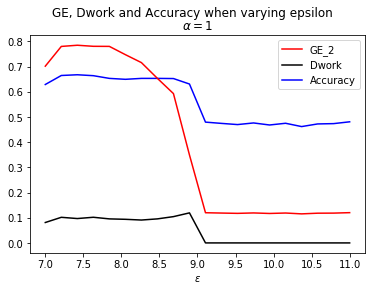

In [29]:
plt.plot(threshold_array, accuracy_array,'b', threshold_array, dwork_array,'k', threshold_array, ge_array, 'r')
plt.suptitle('GE, Dwork and Accuracy when varying epsilon')
plt.title('$\\alpha = 1$')
plt.xlabel('$\epsilon$')
red_line = mlines.Line2D([], [], color='red',
                          markersize=15, label='GE_2')
black_line = mlines.Line2D([], [], color='black',
                          markersize=15, label='Dwork')
blue_line = mlines.Line2D([], [], color='blue',
                          markersize=15, label='Accuracy')
plt.legend(handles=[red_line,black_line,blue_line])
plt.show()